## Flat Earth Experiment

#### Created by Torsten Auerswald (NCAS, University of Reading)

In [2]:
using Pkg

In [3]:
Pkg.status("SpeedyWeather")

Status `~/.julia/environments/v1.11/Project.toml`
  [9e226e20] SpeedyWeather v0.16.0 `https://github.com/SpeedyWeather/SpeedyWeather.jl#main`


In [32]:
#Pkg.add(url="https://github.com/SpeedyWeather/SpeedyWeather.jl",rev="main")

     Cloning git-repo `https://github.com/SpeedyWeather/SpeedyWeather.jl`
    Updating git-repo `https://github.com/SpeedyWeather/SpeedyWeather.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed CompositeTypes ─────────── v0.1.4
   Installed IfElse ─────────────────── v0.1.1
   Installed CommonWorldInvalidations ─ v1.0.0
   Installed Static ─────────────────── v1.2.0
   Installed Functors ───────────────── v0.5.2
   Installed ModelParameters ────────── v0.4.2
   Installed DomainSets ─────────────── v0.7.16
   Installed ComponentArrays ────────── v0.15.29
   Installed StaticArrayInterface ───── v1.8.0
   Installed FieldMetadata ──────────── v0.3.1
   Installed Setfield ───────────────── v1.1.2
   Installed ArrayInterface ─────────── v7.19.0
   Installed AbstractNumbers ────────── v0.2.5
   Installed StringManipulation ─────── v0.4.1
   Installed Flatten ────────────────── v0.4.3
   Installed PrettyTables ───────────── v2.4.0
   

In [4]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="/home/hy913279/summerschool2025/", id="Flat_Earth", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip


NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 10800 seconds
└┐ variables:
 ├ precip_conv: accumulated convective precipitation [mm]
 ├ v: meridional wind [m/s]
 ├ humid: specific humidity [kg/kg]
 ├ temp: temperature [degC]
 ├ u: zonal wind [m/s]
 ├ pres: surface pressure [hPa]
 ├ precip_cond: accumulated large-scale precipitation [mm]
 └ vor: relative vorticity [s^-1]

In [5]:
# Some parameterisation choices
vertical_advection = WENOVerticalAdvection(spectral_grid)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
temperature=LandBucketTemperature(spectral_grid)
soil_moisture=LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid, mixed_layer_depth=50)

#Try to fix ocean albedo
albedo = Albedo(GlobalConstantAlbedo(spectral_grid, albedo=0.06), AlbedoClimatology(spectral_grid))

Albedo <: SpeedyWeather.AbstractAlbedo
├ ocean: GlobalConstantAlbedo{Float32}
└ land: AlbedoClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}

In [6]:
orography=NoOrography(spectral_grid)

NoOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}, LowerTriangularMatrix{ComplexF32, Vector{ComplexF32}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}} <: SpeedyWeather.AbstractOrography
└── arrays: orography, geopot_surf

In [7]:
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(40)) #CPL this is the standar time step

# create model, initialize, run
### Entirely new run
model = PrimitiveWetModel(spectral_grid; orography, vertical_advection, time_stepping, large_scale_condensation, convection, land, ocean, albedo, output=output)

### Continuation run
#initial_conditions = StartFromFile(path="/Users/vidale/SpeedyWeather", id="Climate_Ocean_Land",run_number=24)   # or specify `path` kwarg if not in this folder
#model = PrimitiveWetModel(spectral_grid; initial_conditions, vertical_advection, time_stepping, large_scale_condensation, convection, land, ocean, albedo, output=output)

add!(model, SpeedyWeather.AllOutputVariables()...)
simulation = initialize!(model)
set!(albedo.land, (λ, φ) -> 0., add=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.


3168-element, 48-ring OctahedralGaussianField{Float32, 1} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 0.06982422f0
 ⋮
 0.48046875f0
 0.47851562f0
 0.47851562f0
 0.47851562f0
 0.47851562f0
 0.47851562f0
 0.48046875f0
 0.48046875f0
 0.48046875f0
 0.48046875f0
 0.48046875f0
 0.48046875f0

In [8]:
model

PrimitiveWetModel <: PrimitiveWet
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ dynamics: Bool
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ geopotential: Geopotential{Float32, Vector{Float32}}
├ adiabatic_conversion: AdiabaticConversion{Float32, Vector{Float32}}
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalWind, PressureOnOrography, JablonowskiTemperature,...
├ forcing: NoForcing
├ drag: NoDrag
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ orography: NoOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{Spe...
├ land_sea_mask: EarthLandSeaMask{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussia...
├ 

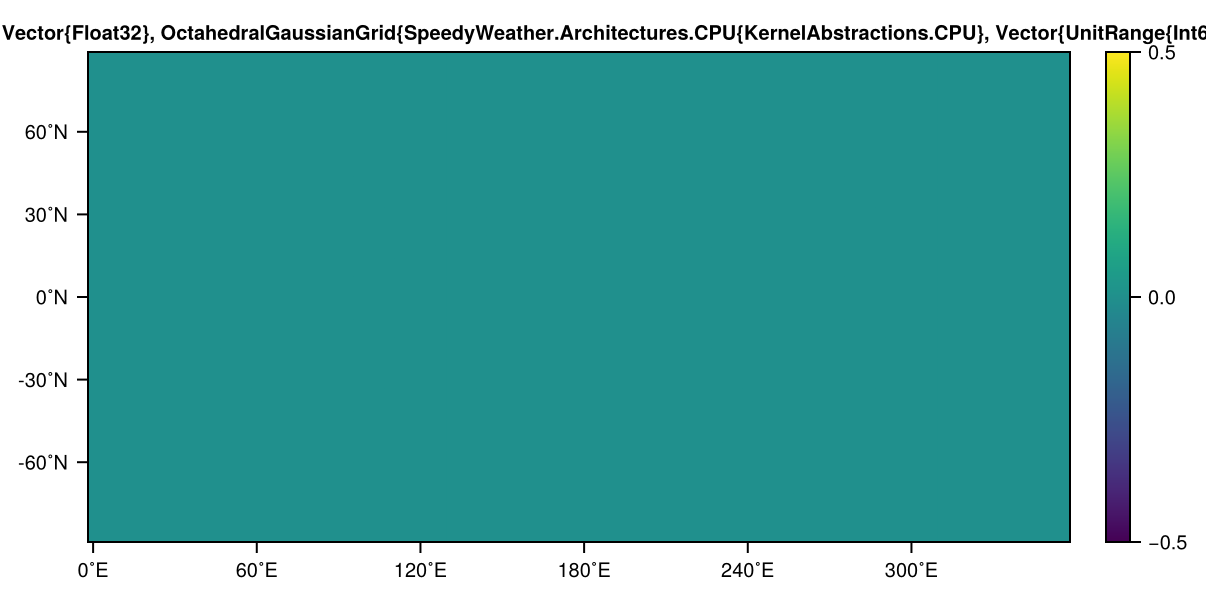

In [7]:
using CairoMakie
heatmap(orography.orography)

In [8]:
run!(simulation, period=Day(30*365), output=true)

Weather is speedy: run_Flat_Earth_0001 100% Time: 1:20:22 (537.43 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}